In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from datetime import datetime 

start_time = datetime.now() 

import time
time.sleep(3)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import glob
from PIL import Image,ImageOps
import random
import os
import time
from datetime import datetime
from os.path import join

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import tensorflow.compat.v1 as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

print("Num GPUs Available: ", len(gpu_devices))

Num GPUs Available:  1


In [ ]:
TRAIN_PATH = '/content/Images/*'
LOGS_Path = "/content/Logs"
CHECKPOINTS_PATH = '/content/Checkpoints'


BATCH_SIZE = 4
LEARNING_RATE = .0001
BETA = .75

EXP_NAME = f"beta_{BETA}"

In [ ]:
print("Total no. of dataset: ", len(glob.glob(TRAIN_PATH)))

Total no. of dataset:  2


In [ ]:
files_list = glob.glob(TRAIN_PATH)

def normalize_batch(imgs):
    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])
                                                        
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

def get_img_batch(files_list,batch_size=32,size=(224,224),should_normalise=True):
   
    batch_cover = []
    batch_secret = []

    for i in range(batch_size):
        img_secret_path = random.choice(files_list)
        img_cover_path = random.choice(files_list)
        
        img_secret = Image.open(img_secret_path).convert("RGB")
        img_cover = Image.open(img_cover_path).convert("RGB")

        img_secret = np.array(ImageOps.fit(img_secret,size),dtype=np.float32)
        img_cover = np.array(ImageOps.fit(img_cover,size),dtype=np.float32)
        
        img_secret /= 255.
        img_cover /= 255.
        
        batch_cover.append(img_cover)
        batch_secret.append(img_secret)
        
    batch_cover,batch_secret = np.array(batch_cover) , np.array(batch_secret)
    
    if should_normalise:
        batch_cover = normalize_batch(batch_cover)
        batch_secret = normalize_batch(batch_secret)

    return batch_cover,batch_secret

In [ ]:
def get_prep_network_op(secret_tensor):
    
    with tf.variable_scope('prep_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)           
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')

        return concat_final

    
def get_hiding_network_op(cover_tensor,prep_output):
    
    with tf.variable_scope('hide_net'):
        concat_input = tf.concat([cover_tensor,prep_output],axis=3,name='images_features_concat')
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)          
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')
        output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')
        
        return output
    
        
        
def get_reveal_network_op(container_tensor):
    
    with tf.variable_scope('reveal_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=3,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=3,padding='same',name="4",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=3,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')
    
    output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')

    return output

def get_noise_layer_op(tensor,std=.1):
    with tf.variable_scope("noise_layer"):
        return tensor + tf.random_normal(shape=tf.shape(tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    
def get_loss_op(secret_true,secret_pred,cover_true,cover_pred,beta=.5):
    
    with tf.variable_scope("losses"):
        beta = tf.constant(beta,name="beta")
        secret_mse = tf.losses.mean_squared_error(secret_true,secret_pred)
        cover_mse = tf.losses.mean_squared_error(cover_true,cover_pred)
        final_loss = cover_mse + beta*secret_mse
        return final_loss , secret_mse , cover_mse 

def get_tensor_to_img_op(tensor):
    with tf.variable_scope("",reuse=True):
        t = tensor*tf.convert_to_tensor([0.229, 0.224, 0.225]) + tf.convert_to_tensor([0.485, 0.456, 0.406])
        return tf.clip_by_value(t,0,1)

In [ ]:
def prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor):
    
    prep_output_op = get_prep_network_op(secret_tensor)
    hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
    noise_add_op = get_noise_layer_op(hiding_output_op)
    reveal_output_op = get_reveal_network_op(noise_add_op)
    
    loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op,beta=BETA)

    minimize_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_op,global_step=global_step_tensor)
    
    tf.summary.scalar('loss', loss_op,family='train')
    tf.summary.scalar('reveal_net_loss', secret_loss_op,family='train')
    tf.summary.scalar('cover_net_loss', cover_loss_op,family='train')

    tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='train')
    tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='train')
    tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='train')
    tf.summary.image('hidden_noisy',get_tensor_to_img_op(noise_add_op),max_outputs=1,family='train')
    tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='train')

    merged_summary_op = tf.summary.merge_all()
    
    return minimize_op, merged_summary_op

In [ ]:
def prepare_test_graph(secret_tensor,cover_tensor):
    with tf.variable_scope("",reuse=True):
    
        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
        reveal_output_op = get_reveal_network_op(hiding_output_op)
        
        loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op)

        tf.summary.scalar('loss', loss_op,family='test')
        tf.summary.scalar('reveal_net_loss', secret_loss_op,family='test')
        tf.summary.scalar('cover_net_loss', cover_loss_op,family='test')

        tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='test')
        tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='test')
        tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='test')
        tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='test')

        merged_summary_op = tf.summary.merge_all()

        return merged_summary_op

In [ ]:
def prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor):
    with tf.variable_scope("",reuse=True):

        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)

        reveal_output_op = get_reveal_network_op(covered_tensor)

        return hiding_output_op ,  reveal_output_op

In [ ]:
sess = tf.InteractiveSession(graph=tf.Graph())

In [ ]:
secret_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_prep")
cover_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_hide")
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')

train_op , summary_op = prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor)

writer = tf.summary.FileWriter(join(LOGS_Path,EXP_NAME),sess.graph)

test_op = prepare_test_graph(secret_tensor,cover_tensor)

covered_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="deploy_covered")
deploy_hide_image_op , deploy_reveal_image_op = prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor)

In [ ]:
saver = tf.train.Saver(max_to_keep=1)
sess.run(tf.global_variables_initializer())

In [ ]:
total_steps = len(files_list)//BATCH_SIZE + 1
BATCH_SIZE

4

In [ ]:
for ep in range(100):
    for step in range(total_steps):
        covers,secrets = get_img_batch(files_list=files_list,batch_size=BATCH_SIZE)
        sess.run([train_op],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
        
        if step % 10 ==0 :
            
            summary,global_step = sess.run([summary_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
            writer.add_summary(summary,global_step)
            
        if step % 100 ==0 :
            
            covers,secrets = get_img_batch(files_list=files_list,batch_size=1)
            summary,global_step = sess.run([test_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
            writer.add_summary(summary,global_step)

    
    save_path = saver.save(sess, join(CHECKPOINTS_PATH,EXP_NAME+".chkp"),global_step=global_step)

In [ ]:
writer.close()

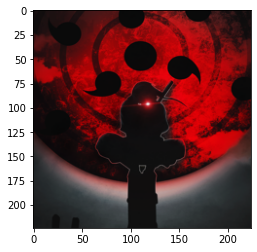

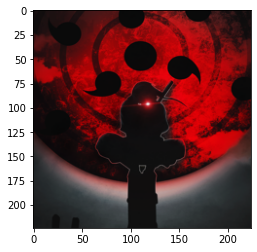

In [ ]:
covers,secrets = get_img_batch(files_list=files_list,batch_size=1)

cover = covers.squeeze()
secret = secrets.squeeze()
plt.imshow(denormalize_batch(cover))
plt.show()
plt.imshow(denormalize_batch(secret))
plt.show()

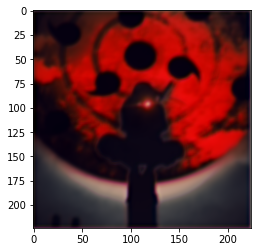

In [ ]:
hidden = sess.run(deploy_hide_image_op,feed_dict={'input_prep:0':secrets,'input_hide:0':covers})

plt.imshow(denormalize_batch(hidden.squeeze()))

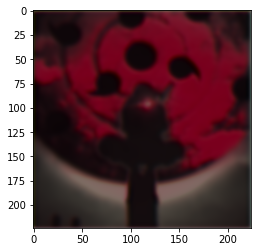

In [ ]:
revealed = sess.run(deploy_reveal_image_op,feed_dict={'deploy_covered:0':hidden})

plt.imshow(denormalize_batch(revealed.squeeze()))

In [ ]:
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:03:38.028616
